In [2]:
!pip install kaggle_environments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 7.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.8 MB/s eta 0:00:00
  Using cached Werkzeug-2.2.2-py3-none-any.whl (232 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 3.1 MB/s eta 0:00:00


In [3]:
from kaggle_environments import make, evaluate

# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

Loading environment lux_ai_2022 failed: No module named 'vec_noise'


In [4]:
"""
Your submission should be a python file with the last 'def' accepting an observation and returning an action. You can also upload multiple files in a zip/gz/7z archive with a main.py at the top level.
"""

import random
import numpy as np

# Gets board at next step if agent drops piece in selected column
def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

# Helper function for get_heuristic: checks if window satisfies heuristic conditions
def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)
    
# Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
def find_spots_1(grid, num_discs, piece, config):
    good_spots = []
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row+i,col
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row+i,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row-i,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    return good_spots

# Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
def count_windows_1(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

# Calculate spots
def get_heuristic_1(grid, mark, config):
    score = 0
    for i,num in enumerate(range(3, config.inarow)):
        weight = 100**i
        good_spots = find_spots_1(grid, num, mark, config)
        good_spots_opp = find_spots_1(grid, num, mark%2+1, config)
        score += weight * len(good_spots) - 10 * weight * len(good_spots_opp)
    weight = 100**(config.inarow - 3) 
    num_wins = count_windows_1(grid, config.inarow, mark, config)
    num_wins_opp = count_windows_1(grid, config.inarow, mark%2+1, config)
    score += weight * num_wins - 10 * weight * num_wins_opp
    return score

# Uses minimax to calculate value of dropping piece in selected column
def score_move_1(grid, col, mark, config, nsteps):
    next_grid = drop_piece(grid, col, mark, config)
    score = minimax_1(next_grid, nsteps-1, False, mark, config)
    return score

# Helper function for minimax: checks if agent or opponent has four in a row in the window
def is_terminal_window(window, config):
    return window.count(1) == config.inarow or window.count(2) == config.inarow

# Helper function for minimax: checks if game has ended
def is_terminal_node(grid, config):
    # Check for draw 
    if list(grid[0, :]).count(0) == 0:
        return True
    # Check for win: horizontal, vertical, or diagonal
    # horizontal 
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if is_terminal_window(window, config):
                return True
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if is_terminal_window(window, config):
                return True
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    return False

# Minimax implementation
def minimax_1(node, depth, maximizingPlayer, mark, config):
    is_terminal = is_terminal_node(node, config)
    valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
    if depth == 0 or is_terminal:
        return get_heuristic_1(node, mark, config)
    if maximizingPlayer:
        value = -np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark, config)
            value = max(value, minimax_1(child, depth-1, False, mark, config))
        return value
    else:
        value = np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark%2+1, config)
            value = min(value, minimax_1(child, depth-1, True, mark, config))
        return value
    
# How deep to make the game tree: higher values take longer to run!
N_STEPS = 3

def agent_1(obs, config):
    # Get list of valid moves
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    # Use the heuristic to assign a score to each possible board in the next step
    scores = dict(zip(valid_moves, [score_move_1(grid, col, obs.mark, config, N_STEPS) for col in valid_moves]))
    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    # Select at random from the maximizing columns
    return random.choice(max_cols)



In [5]:
"""
Your submission should be a python file with the last 'def' accepting an observation and returning an action. You can also upload multiple files in a zip/gz/7z archive with a main.py at the top level.
"""

import random
import numpy as np

# Gets board at next step if agent drops piece in selected column
def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

# Helper function for get_heuristic: checks if window satisfies heuristic conditions
def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)
    
# Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
def find_spots_2(grid, num_discs, piece, config):
    good_spots = []
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row+i,col
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row+i,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row-i,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    return good_spots

# Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
def count_windows_2(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

# Calculate spots from 0
def get_heuristic_2(grid, mark, config):
    score = 0
    for i,num in enumerate(range(0, config.inarow)):
        weight = 100**i
        good_spots = find_spots_2(grid, num, mark, config)
        good_spots_opp = find_spots_2(grid, num, mark%2+1, config)
        score += weight * len(good_spots) - 10 * weight * len(good_spots_opp)
    weight = 100**(config.inarow) 
    num_wins = count_windows_2(grid, config.inarow, mark, config)
    num_wins_opp = count_windows_2(grid, config.inarow, mark%2+1, config)
    score += weight * num_wins - 10 * weight * num_wins_opp
    return score

# Uses minimax to calculate value of dropping piece in selected column
def score_move_2(grid, col, mark, config, nsteps):
    next_grid = drop_piece(grid, col, mark, config)
    score = minimax_2(next_grid, nsteps-1, False, mark, config)
    return score

# Helper function for minimax: checks if agent or opponent has four in a row in the window
def is_terminal_window(window, config):
    return window.count(1) == config.inarow or window.count(2) == config.inarow

# Helper function for minimax: checks if game has ended
def is_terminal_node(grid, config):
    # Check for draw 
    if list(grid[0, :]).count(0) == 0:
        return True
    # Check for win: horizontal, vertical, or diagonal
    # horizontal 
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if is_terminal_window(window, config):
                return True
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if is_terminal_window(window, config):
                return True
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    return False

# Minimax implementation
def minimax_2(node, depth, maximizingPlayer, mark, config):
    is_terminal = is_terminal_node(node, config)
    valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
    if depth == 0 or is_terminal:
        return get_heuristic_2(node, mark, config)
    if maximizingPlayer:
        value = -np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark, config)
            value = max(value, minimax_2(child, depth-1, False, mark, config))
        return value
    else:
        value = np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark%2+1, config)
            value = min(value, minimax_2(child, depth-1, True, mark, config))
        return value
    
# How deep to make the game tree: higher values take longer to run!
N_STEPS = 3

def agent(obs, config):
    # Get list of valid moves
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    # Use the heuristic to assign a score to each possible board in the next step
    scores = dict(zip(valid_moves, [score_move_2(grid, col, obs.mark, config, N_STEPS) for col in valid_moves]))
    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    # Select at random from the maximizing columns
    return random.choice(max_cols)


In [6]:
"""
Your submission should be a python file with the last 'def' accepting an observation and returning an action. You can also upload multiple files in a zip/gz/7z archive with a main.py at the top level.
"""

import random
import numpy as np

# Gets board at next step if agent drops piece in selected column
def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

# Helper function for get_heuristic: checks if window satisfies heuristic conditions
def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)
    
# Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
def find_spots_3(grid, num_discs, piece, config):
    good_spots = []
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row+i,col
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row+i,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                for i,spot in enumerate(window):
                    r,c = row-i,col+i
                    assert grid[r,c] == spot
                    if (r,c) not in good_spots and spot == 0:
                        good_spots.append((r,c))
    return good_spots

# Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
def count_windows_3(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

# Calculate spots from 0 + Adjacency bonus
def get_heuristic_3(grid, mark, config):
    score = 0
    for i,num in enumerate(range(0, config.inarow-1)):
        weight = 10**i 
        num_wins = count_windows_3(grid, num, mark, config)
        num_wins_opp = count_windows_3(grid, num, mark%2+1, config)
        score += weight * num_wins - 5 * weight * num_wins_opp
    weight = 10**(config.inarow-1) 
    good_spots = find_spots_3(grid, num, mark, config)
    good_spots_opp = find_spots_3(grid, num, mark%2+1, config)
    score += weight * len(good_spots) - 5 * weight * len(good_spots_opp)
    weight = 10**(config.inarow) 
    # Adjacency bonus
    prev_c, prev_r = -1, -1 
    for c,r in sorted([(c,r) for r,c in good_spots]):
        if c == prev_c and r == prev_r + 1:
            score += weight
        prev_c, prev_r = c, r
    prev_c, prev_r = -1, -1 
    for c,r in sorted([(c,r) for r,c in good_spots_opp]):
        if c == prev_c and r == prev_r + 1:
            score -= weight
        prev_c, prev_r = c, r
    weight = 10**(config.inarow+1) 
    num_wins = count_windows_3(grid, config.inarow, mark, config)
    num_wins_opp = count_windows_3(grid, config.inarow, mark%2+1, config)
    score += weight * num_wins - 5 * weight * num_wins_opp
    return score

# Uses minimax to calculate value of dropping piece in selected column
def score_move_3(grid, col, mark, config, nsteps):
    next_grid = drop_piece(grid, col, mark, config)
    score = minimax_3(next_grid, nsteps-1, False, mark, config)
    return score

# Helper function for minimax: checks if agent or opponent has four in a row in the window
def is_terminal_window(window, config):
    return window.count(1) == config.inarow or window.count(2) == config.inarow

# Helper function for minimax: checks if game has ended
def is_terminal_node(grid, config):
    # Check for draw 
    if list(grid[0, :]).count(0) == 0:
        return True
    # Check for win: horizontal, vertical, or diagonal
    # horizontal 
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if is_terminal_window(window, config):
                return True
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if is_terminal_window(window, config):
                return True
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    return False

# Minimax implementation
def minimax_3(node, depth, maximizingPlayer, mark, config):
    is_terminal = is_terminal_node(node, config)
    valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
    if depth == 0 or is_terminal:
        return get_heuristic_3(node, mark, config)
    if maximizingPlayer:
        value = -np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark, config)
            value = max(value, minimax_3(child, depth-1, False, mark, config))
        return value
    else:
        value = np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark%2+1, config)
            value = min(value, minimax_3(child, depth-1, True, mark, config))
        return value
    
# How deep to make the game tree: higher values take longer to run!
N_STEPS = 3

def agent_3(obs, config):
    # Get list of valid moves
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    # Use the heuristic to assign a score to each possible board in the next step
    scores = dict(zip(valid_moves, [score_move_3(grid, col, obs.mark, config, N_STEPS) for col in valid_moves]))
    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    # Select at random from the maximizing columns
    return random.choice(max_cols)


In [7]:
"""
Your submission should be a python file with the last 'def' accepting an observation and returning an action. You can also upload multiple files in a zip/gz/7z archive with a main.py at the top level.
"""

import random
import numpy as np

# Gets board at next step if agent drops piece in selected column
def drop_piece(grid, col, mark, config):
    next_grid = grid.copy()
    for row in range(config.rows-1, -1, -1):
        if next_grid[row][col] == 0:
            break
    next_grid[row][col] = mark
    return next_grid

# Helper function for get_heuristic: checks if window satisfies heuristic conditions
def check_window(window, num_discs, piece, config):
    return (window.count(piece) == num_discs and window.count(0) == config.inarow-num_discs)
    
# Helper function for get_heuristic: counts number of windows satisfying specified heuristic conditions
def count_windows(grid, num_discs, piece, config):
    num_windows = 0
    # horizontal
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if check_window(window, num_discs, piece, config):
                num_windows += 1
    return num_windows

# Helper function for minimax: calculates value of heuristic for grid
def get_heuristic(grid, mark, config):
    num_threes = count_windows(grid, 3, mark, config)
    num_fours = count_windows(grid, 4, mark, config)
    num_threes_opp = count_windows(grid, 3, mark%2+1, config)
    num_fours_opp = count_windows(grid, 4, mark%2+1, config)
    score = num_threes - 1e2*num_threes_opp - 1e4*num_fours_opp + 1e6*num_fours
    return score

# Uses minimax to calculate value of dropping piece in selected column
def score_move(grid, col, mark, config, nsteps):
    next_grid = drop_piece(grid, col, mark, config)
    score = minimax(next_grid, nsteps-1, False, mark, config)
    return score

# Helper function for minimax: checks if agent or opponent has four in a row in the window
def is_terminal_window(window, config):
    return window.count(1) == config.inarow or window.count(2) == config.inarow

# Helper function for minimax: checks if game has ended
def is_terminal_node(grid, config):
    # Check for draw 
    if list(grid[0, :]).count(0) == 0:
        return True
    # Check for win: horizontal, vertical, or diagonal
    # horizontal 
    for row in range(config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[row, col:col+config.inarow])
            if is_terminal_window(window, config):
                return True
    # vertical
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns):
            window = list(grid[row:row+config.inarow, col])
            if is_terminal_window(window, config):
                return True
    # positive diagonal
    for row in range(config.rows-(config.inarow-1)):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    # negative diagonal
    for row in range(config.inarow-1, config.rows):
        for col in range(config.columns-(config.inarow-1)):
            window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
            if is_terminal_window(window, config):
                return True
    return False

# Minimax implementation
def minimax(node, depth, maximizingPlayer, mark, config):
    is_terminal = is_terminal_node(node, config)
    valid_moves = [c for c in range(config.columns) if node[0][c] == 0]
    if depth == 0 or is_terminal:
        return get_heuristic(node, mark, config)
    if maximizingPlayer:
        value = -np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark, config)
            value = max(value, minimax(child, depth-1, False, mark, config))
        return value
    else:
        value = np.Inf
        for col in valid_moves:
            child = drop_piece(node, col, mark%2+1, config)
            value = min(value, minimax(child, depth-1, True, mark, config))
        return value
    
# How deep to make the game tree: higher values take longer to run!
N_STEPS = 3

def agent(obs, config):
    # Get list of valid moves
    valid_moves = [c for c in range(config.columns) if obs.board[c] == 0]
    # Convert the board to a 2D grid
    grid = np.asarray(obs.board).reshape(config.rows, config.columns)
    # Use the heuristic to assign a score to each possible board in the next step
    scores = dict(zip(valid_moves, [score_move(grid, col, obs.mark, config, N_STEPS) for col in valid_moves]))
    # Get a list of columns (moves) that maximize the heuristic
    max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
    # Select at random from the maximizing columns
    return random.choice(max_cols)

In [48]:
def get_win_percentages(agent1, agent2, n_rounds=50):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

In [109]:
get_win_percentages(agent1=agent, agent2=agent_1)

Agent 1 Win Percentage: 0.44
Agent 2 Win Percentage: 0.46
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [110]:
get_win_percentages(agent1=agent, agent2=agent_2)

Agent 1 Win Percentage: 0.22
Agent 2 Win Percentage: 0.64
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [108]:
get_win_percentages(agent1=agent, agent2=agent_3)

Agent 1 Win Percentage: 0.12
Agent 2 Win Percentage: 0.78
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


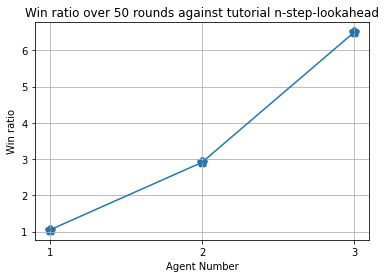

In [128]:
import matplotlib.pyplot as plt
plt.plot([1,2,3], [0.46/0.44, 0.64/0.22, 0.78/0.12])
plt.scatter([1,2,3], [0.46/0.44, 0.64/0.22, 0.78/0.12], marker='*', linewidths=5)
plt.xticks([1,2,3])
plt.grid()
plt.xlabel("Agent Number")
plt.ylabel("Win ratio")
plt.title("Win ratio over 50 rounds against tutorial n-step-lookahead");

In [8]:
env.run([agent_3, agent])
# Show the game
env.render(mode="ipython")

In [133]:
env.run([agent_3, agent])
# Show the game
env.render(mode="ipython")

In [43]:
class state:
    def __init__(self, board, mark):
        self.board = board
        self.mark = mark
class configuration:
    def __init__(self):
        self.columns = 7
        self.rows = 6
        self.inarow = 4
        
board = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0]

agent_3(state(board, 2), configuration())

1

In [44]:
np.array(board).reshape(6,7)

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 2, 0],
       [0, 0, 0, 2, 1, 2, 0],
       [0, 0, 0, 1, 2, 1, 0],
       [0, 0, 1, 2, 1, 1, 0],
       [0, 0, 1, 2, 2, 1, 0]])